In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import pathlib
import sys
import pandas as pd
sys.path.append('../dataset/')
sys.path.append('../models/')
from PIL import Image
from unet import unet_2D, UNet
import torch
from catalyst import dl, metrics, utils;
import albumentations as A
from dataset import AsbestosDataSet
from torch.utils.data import DataLoader
from torch import nn

In [2]:
image_dir = '../../task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/JPEGImages/asbestos/stones/161220'
mask_dir  = '../../task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/SegmentationAsbest'
t_h = 256
t_h = 512
transform = A.Compose([A.RandomCrop(width=512*3, height=512*3),
                       A.Resize(t_h,t_h), A.RandomRotate90()])

crop_size = 640
transform = A.Compose([A.RandomCrop(width=crop_size, height=crop_size),
                       A.RandomRotate90()])

dataset = AsbestosDataSet(image_dir, mask_dir, transform)
data_loader = DataLoader(dataset, num_workers=1, batch_size = 2,)
loaders = {"train":data_loader}

In [3]:
image, mask, name = next(data_loader.__iter__()).values()
print(image[0], mask[0])

tensor([[0.4235, 0.4314, 0.4941,  ..., 0.1882, 0.1882, 0.2118],
        [0.3922, 0.3922, 0.4275,  ..., 0.1961, 0.2078, 0.2157],
        [0.3843, 0.4039, 0.4157,  ..., 0.2196, 0.2275, 0.2471],
        ...,
        [0.7176, 0.6980, 0.5765,  ..., 0.6039, 0.6039, 0.5922],
        [0.6941, 0.5725, 0.4706,  ..., 0.6471, 0.6627, 0.6980],
        [0.4667, 0.4157, 0.4039,  ..., 0.5804, 0.6627, 0.7608]]) tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [4]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth=1e-5):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice
    
# class DiceLoss(nn.Module):
#     """
#         prediction (P): Предсказываемая разметка
#         target     (T): Целевая разметка
#         Функция Даеса.
#         Находит отношение пересечения A и T к объединению A и T.
#         Результат вычитается из единицы с целью использования при оптимизации.
#     """
#     def __init__(self):
#         super().__init__()
#     def forward(self, prediction, target):
#         assert prediction.size() == target.size()
#         prediction = prediction.view(-1)
#         target = target.view(-1)
#         intersection = (prediction*target).sum()
#         # union=(prediction*prediction).sum() + (target*target).sum() + 1e-6
#         # dcs = (2. * intersection)/union
#         union=((1-prediction)*target).sum()+(prediction*(1-target)).sum()+intersection + 1e-6
#         return 1-intersection/union
    
DiceLoss().forward(torch.tensor([0,1,1,1]),torch.tensor([0,1,1,1]))

tensor(0.)

In [5]:
class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        return self.model(batch['image'].to(self.device))
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = { key: metrics.AdditiveValueMetric(compute_on_call=True)
                        for key in ["loss", "iou"]}
        
    def handle_batch(self, batch):
        image, mask, name = batch.values()
        #----------
        image = image.unsqueeze(1)
        mask  = mask.unsqueeze(1)
#         mask  = torch.tensor(mask, dtype = torch.long)
        #------------
        predict = self.model(image)#batch size
#         print(image.shape, image.type(), mask.shape, mask.type())
        loss = self.criterion(predict, mask)
        #Создаем обьект
        iou_metric = metrics.IOUMetric()
        iou = iou_metric.update_key_value(predict, mask)['iou']
        self.batch_metrics.update(
            {"loss": loss, "iou": iou}
        )
        for key in ["loss", "iou"]:
            self.meters[key].update( self.batch_metrics[key].item(), self.batch_size)
        iou_metric.reset()
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
    def on_loader_end(self, runner):
        for key in ["loss", "iou"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)   

In [6]:
t1 = torch.tensor([[1,0,1]])
t2 = torch.tensor([[1,0,0.9]])

iou_metric = metrics.IOUMetric()
iou = iou_metric.update_key_value(t1,t2)['iou']
iou

tensor(0.9667)

In [7]:
unet = unet_2D(feature_scale=1, n_classes = 1, 
               in_channels=1, is_deconv = True,
               is_debug=False, )
unet = UNet(n_channels=1, n_classes = 1 )

In [8]:
criterion = DiceLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters())
runner = CustomRunner()
runner.train(
    model=unet,
    criterion = criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=300,
    logdir = 'unet_log',
    verbose=True)

/home/office/kirilman/miniconda3/lib/python3.8/site-packages/catalyst/core/runner.py:623: UserWarning: No ``ICriterionCallback/CriterionCallback`` were found while runner.criterion is not None.Do you compute the loss during ``runner.handle_batch``?
  warnings.warn(
/home/office/kirilman/miniconda3/lib/python3.8/site-packages/catalyst/core/runner.py:629: UserWarning: No ``IOptimizerCallback/OptimizerCallback`` were found while runner.optimizer is not None.Do run backward pass during ``runner.handle_batch``?
  warnings.warn(


/home/office/kirilman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



train (1/300) iou: 0.03492701758391616 | loss: 0.9349959063948247
* Epoch (1/300) 



train (2/300) iou: 0.04266128319432027 | loss: 0.9212174812952677
* Epoch (2/300) 



train (3/300) iou: 0.05306526004099858 | loss: 0.9021439175856741
* Epoch (3/300) 



train (4/300) iou: 0.04476147482433078 | loss: 0.9181095382623506
* Epoch (4/300) 



train (5/300) iou: 0.05035950888454783 | loss: 0.9081606132942334
* Epoch (5/300) 



train (6/300) iou: 0.05782279295422006 | loss: 0.8958207368850709
* Epoch (6/300) 



train (7/300) iou: 0.05881290433503556 | loss: 0.8934806857192725
* Epoch (7/300) 



train (8/300) iou: 0.06225746389380921 | loss: 0.891468326250712
* Epoch (8/300) 



train (9/300) iou: 0.07112402643746973 | loss: 0.8747479988817581
* Epoch (9/300) 



train (10/300) iou: 0.06163990956867979 | loss: 0.8887111680549489
* Epoch (10/300) 



train (11/300) iou: 0.07035247815605417 | loss: 0.8807664022111056
* Epoch (11/300) 



train (12/300) iou: 0.053485277108848095 | loss: 0.9046390453974406
* Epoch (12/300) 



train (13/300) iou: 0.06579642961687089 | loss: 0.8842785881276716
* Epoch (13/300) 



train (14/300) iou: 0.09693796427711535 | loss: 0.8307461173910844
* Epoch (14/300) 



train (15/300) iou: 0.06919676911084544 | loss: 0.8795122640174732
* Epoch (15/300) 



train (16/300) iou: 0.06834645573335843 | loss: 0.8809747162618135
* Epoch (16/300) 



train (17/300) iou: 0.04128822279052888 | loss: 0.9267406024430926
* Epoch (17/300) 



train (18/300) iou: 0.05268896857913269 | loss: 0.9062651458539461
* Epoch (18/300) 



train (19/300) iou: 0.07647113716679119 | loss: 0.8681083049690513
* Epoch (19/300) 



train (20/300) iou: 0.06882080101097114 | loss: 0.8817587087028904
* Epoch (20/300) 



train (21/300) iou: 0.07424145804211628 | loss: 0.8708645523640147
* Epoch (21/300) 



train (22/300) iou: 0.06346803174860645 | loss: 0.8876306310034634
* Epoch (22/300) 



train (23/300) iou: 0.057424921081595436 | loss: 0.900260661777697
* Epoch (23/300) 



train (24/300) iou: 0.0478467676633348 | loss: 0.9135815532583939
* Epoch (24/300) 



train (25/300) iou: 0.07752286191757057 | loss: 0.8643066517093725
* Epoch (25/300) 



train (26/300) iou: 0.06645261741824357 | loss: 0.8857735301318922
* Epoch (26/300) 


* Epoch (27/300) 



train (28/300) iou: 0.06599013067308765 | loss: 0.8850615087308382
* Epoch (28/300) 



train (29/300) iou: 0.08676103424901763 | loss: 0.8551752253582603
* Epoch (29/300) 



train (30/300) iou: 0.07702866241488025 | loss: 0.8683273290332996
* Epoch (30/300) 



train (31/300) iou: 0.06504927132750468 | loss: 0.8855432794805159
* Epoch (31/300) 



train (32/300) iou: 0.07624372565563439 | loss: 0.864942068593544
* Epoch (32/300) 



train (33/300) iou: 0.09585929517389129 | loss: 0.8349640515812656
* Epoch (33/300) 



train (34/300) iou: 0.0827361142787196 | loss: 0.8554305643366094
* Epoch (34/300) 



train (35/300) iou: 0.08464127885784826 | loss: 0.8540484152342144
* Epoch (35/300) 



train (36/300) iou: 0.14098955623688977 | loss: 0.7744390420746385
* Epoch (36/300) 



train (37/300) iou: 0.09999532288904385 | loss: 0.8305940063376176
* Epoch (37/300) 



train (38/300) iou: 0.07748569139755744 | loss: 0.8676251486728067
* Epoch (38/300) 



train (39/300) iou: 0.054441614978458626 | loss: 0.9011704419788563
* Epoch (39/300) 



train (40/300) iou: 0.0832837287238554 | loss: 0.8550610782807334
* Epoch (40/300) 



train (41/300) iou: 0.10505733065059929 | loss: 0.8204638100506966
* Epoch (41/300) 



train (42/300) iou: 0.06687574649546772 | loss: 0.8816487266306291
* Epoch (42/300) 



train (43/300) iou: 0.05928580418219161 | loss: 0.8960981442217241
* Epoch (43/300) 



train (44/300) iou: 0.09913278703540004 | loss: 0.8319601050594397
* Epoch (44/300) 



train (45/300) iou: 0.07477873720718962 | loss: 0.8725200870580841
* Epoch (45/300) 



train (46/300) iou: 0.09124881537870247 | loss: 0.845358499309473
* Epoch (46/300) 



train (47/300) iou: 0.09395831611957697 | loss: 0.8391767802991366
* Epoch (47/300) 



train (48/300) iou: 0.0874098794910216 | loss: 0.8482169080198856
* Epoch (48/300) 



train (49/300) iou: 0.07838074310085642 | loss: 0.8631237243351183
* Epoch (49/300) 



train (50/300) iou: 0.06987856084256258 | loss: 0.8772820903543841
* Epoch (50/300) 



train (51/300) iou: 0.0808377210063267 | loss: 0.8582969903945922
* Epoch (51/300) 



train (52/300) iou: 0.0796833531277483 | loss: 0.8609073684926621
* Epoch (52/300) 



train (53/300) iou: 0.08271939627695502 | loss: 0.857211452827119
* Epoch (53/300) 



train (54/300) iou: 0.0950620789407638 | loss: 0.8342877919213815
* Epoch (54/300) 



train (55/300) iou: 0.05996397007252704 | loss: 0.8955979483169422
* Epoch (55/300) 



train (56/300) iou: 0.07010571904634401 | loss: 0.8802058602634228
* Epoch (56/300) 



train (57/300) iou: 0.08329782631909964 | loss: 0.8564590864014208
* Epoch (57/300) 



train (58/300) iou: 0.09481116033592178 | loss: 0.8403040766716005
* Epoch (58/300) 



train (59/300) iou: 0.09287571106024346 | loss: 0.8411937941584671
* Epoch (59/300) 



train (60/300) iou: 0.08287354301605893 | loss: 0.859455058449193
* Epoch (60/300) 



train (61/300) iou: 0.09087865364777793 | loss: 0.8435221366715013
* Epoch (61/300) 



train (62/300) iou: 0.08947485187955818 | loss: 0.8467418279564173
* Epoch (62/300) 



train (63/300) iou: 0.10155477670259007 | loss: 0.8319993562865674
* Epoch (63/300) 



train (64/300) iou: 0.07146789834224805 | loss: 0.8745731596361128
* Epoch (64/300) 



train (65/300) iou: 0.0921572827420006 | loss: 0.8386154687195493
* Epoch (65/300) 



train (66/300) iou: 0.08082752435959997 | loss: 0.8594680240279748
* Epoch (66/300) 



train (67/300) iou: 0.09968578983716726 | loss: 0.8308593996784144
* Epoch (67/300) 



train (68/300) iou: 0.10054714109732264 | loss: 0.8283917851615369
* Epoch (68/300) 



train (69/300) iou: 0.11666754293337205 | loss: 0.8046738076628299
* Epoch (69/300) 



train (70/300) iou: 0.0743775465117212 | loss: 0.87027550057361
* Epoch (70/300) 



train (71/300) iou: 0.09143655665933455 | loss: 0.8422583090631587
* Epoch (71/300) 



train (72/300) iou: 0.10879410573112147 | loss: 0.8194099288237723
* Epoch (72/300) 



train (73/300) iou: 0.08864243484608697 | loss: 0.8464793050498294
* Epoch (73/300) 



train (74/300) iou: 0.06631974469150342 | loss: 0.882677043739118
* Epoch (74/300) 



train (75/300) iou: 0.08387615405766916 | loss: 0.8551648405560275
* Epoch (75/300) 



train (76/300) iou: 0.09268594723867034 | loss: 0.845886140538935
* Epoch (76/300) 



train (77/300) iou: 0.10013341251196675 | loss: 0.8296420772870381
* Epoch (77/300) 



train (78/300) iou: 0.11018763042557113 | loss: 0.8164847263118677
* Epoch (78/300) 



train (79/300) iou: 0.0857042423665302 | loss: 0.85473600814217
* Epoch (79/300) 



train (80/300) iou: 0.0847590466470345 | loss: 0.8517345001823022
* Epoch (80/300) 



train (81/300) iou: 0.08137627828696888 | loss: 0.8620776251742713
* Epoch (81/300) 



train (82/300) iou: 0.0751290503929723 | loss: 0.8749837624399286
* Epoch (82/300) 



train (83/300) iou: 0.0895592896085713 | loss: 0.8445483989882888
* Epoch (83/300) 



train (84/300) iou: 0.1004605588274436 | loss: 0.8284439956932738
* Epoch (84/300) 



train (85/300) iou: 0.09761187380877745 | loss: 0.8376680706676684
* Epoch (85/300) 



train (86/300) iou: 0.06909687938822205 | loss: 0.877388692738717
* Epoch (86/300) 



train (89/300) iou: 0.07746017940568987 | loss: 0.867180316071761
* Epoch (89/300) 



train (90/300) iou: 0.08357411169598095 | loss: 0.8576075016406544
* Epoch (90/300) 



train (91/300) iou: 0.08307605610829534 | loss: 0.8586201270421344
* Epoch (91/300) 



train (92/300) iou: 0.06964968790819975 | loss: 0.8785521063888282
* Epoch (92/300) 



train (93/300) iou: 0.09379086489055528 | loss: 0.8426121828848856
* Epoch (93/300) 



train (94/300) iou: 0.09119579605051219 | loss: 0.8482183050691036
* Epoch (94/300) 



train (95/300) iou: 0.10852401585751129 | loss: 0.8161620863696984
* Epoch (95/300) 



train (96/300) iou: 0.08825886156869912 | loss: 0.8501091798146566
* Epoch (96/300) 



train (97/300) iou: 0.13946460254833498 | loss: 0.773787642780103
* Epoch (97/300) 



train (98/300) iou: 0.1241656910212157 | loss: 0.7935140237473605
* Epoch (98/300) 



train (99/300) iou: 0.10745861127902483 | loss: 0.8230001424488269
* Epoch (99/300) 



train (100/300) iou: 0.11294903320652483 | loss: 0.8150693920620701
* Epoch (100/300) 



train (101/300) iou: 0.13305053917277795 | loss: 0.7857898933845654
* Epoch (101/300) 



train (102/300) iou: 0.08071883424239337 | loss: 0.860637647018098
* Epoch (102/300) 



train (103/300) iou: 0.08675426237703887 | loss: 0.8518948973270885
* Epoch (103/300) 



train (104/300) iou: 0.10007602485904407 | loss: 0.8303653273666115
* Epoch (104/300) 



train (105/300) iou: 0.08422924787240749 | loss: 0.8577741823698344
* Epoch (105/300) 



train (106/300) iou: 0.11515050178001585 | loss: 0.8058110956560101
* Epoch (106/300) 



train (107/300) iou: 0.09018777912123162 | loss: 0.846689537951821
* Epoch (107/300) 



train (108/300) iou: 0.0928535341374874 | loss: 0.8437341022909733
* Epoch (108/300) 



train (109/300) iou: 0.0832279028283601 | loss: 0.8560778958755627
* Epoch (109/300) 



train (110/300) iou: 0.1207595567054995 | loss: 0.7994110636543809
* Epoch (110/300) 



train (111/300) iou: 0.0891509465925697 | loss: 0.8511869823723509
* Epoch (111/300) 



train (112/300) iou: 0.08882436958386579 | loss: 0.8500141752393623
* Epoch (112/300) 



train (113/300) iou: 0.09837218069801344 | loss: 0.8357057749179373
* Epoch (113/300) 



train (114/300) iou: 0.11450623294482111 | loss: 0.8061185552362812
* Epoch (114/300) 



train (115/300) iou: 0.13941340407421976 | loss: 0.7693422949104979
* Epoch (115/300) 



train (116/300) iou: 0.10792690402631147 | loss: 0.8229516786441469
* Epoch (116/300) 



train (117/300) iou: 0.10384754226297928 | loss: 0.8274597149146231
* Epoch (117/300) 



train (118/300) iou: 0.07533055881437703 | loss: 0.8696410363180596
* Epoch (118/300) 



train (119/300) iou: 0.0846182542955559 | loss: 0.8551408387067024
* Epoch (119/300) 



train (120/300) iou: 0.09038722114800883 | loss: 0.8512261290299264
* Epoch (120/300) 



train (121/300) iou: 0.10910891660798855 | loss: 0.819586435953776
* Epoch (121/300) 



train (122/300) iou: 0.09710110916772434 | loss: 0.8353588894793861
* Epoch (122/300) 



train (123/300) iou: 0.1182975333277625 | loss: 0.8052511058355631
* Epoch (123/300) 



train (124/300) iou: 0.12654427647296532 | loss: 0.7929588294865791
* Epoch (124/300) 



train (125/300) iou: 0.09399784634118541 | loss: 0.8395713044886005
* Epoch (125/300) 



train (126/300) iou: 0.08339640472746623 | loss: 0.8590204506589656
* Epoch (126/300) 



train (127/300) iou: 0.10338482123161609 | loss: 0.8277003744192292
* Epoch (127/300) 



train (128/300) iou: 0.09469717569300423 | loss: 0.8356605830945467
* Epoch (128/300) 



train (129/300) iou: 0.08764032301941799 | loss: 0.852194907372458
* Epoch (129/300) 



train (130/300) iou: 0.11032650586575024 | loss: 0.8124832751458151
* Epoch (130/300) 



train (131/300) iou: 0.11279641312399977 | loss: 0.808915656909608
* Epoch (131/300) 



train (132/300) iou: 0.10295810974550253 | loss: 0.8298738922989158
* Epoch (132/300) 



train (133/300) iou: 0.12617224998028145 | loss: 0.791113211397539
* Epoch (133/300) 



train (134/300) iou: 0.09320581809885896 | loss: 0.8447033867501377
* Epoch (134/300) 



train (135/300) iou: 0.11935398165764997 | loss: 0.8041433639693678
* Epoch (135/300) 



train (136/300) iou: 0.09295012454898437 | loss: 0.8452600083853069
* Epoch (136/300) 



train (137/300) iou: 0.09909722635859752 | loss: 0.8353341901511478
* Epoch (137/300) 



train (138/300) iou: 0.12410701198774365 | loss: 0.8004533930828698
* Epoch (138/300) 



train (139/300) iou: 0.09051606736333222 | loss: 0.8439363460791739
* Epoch (139/300) 



train (140/300) iou: 0.16204935021179478 | loss: 0.7385656018006175
* Epoch (140/300) 



train (141/300) iou: 0.11043519475681597 | loss: 0.8137133727993882
* Epoch (141/300) 



train (142/300) iou: 0.10071478900121782 | loss: 0.8322801140316746
* Epoch (142/300) 



train (143/300) iou: 0.11059309904030201 | loss: 0.8130881744518614
* Epoch (143/300) 



train (144/300) iou: 0.09029295211963562 | loss: 0.850190846543563
* Epoch (144/300) 



train (145/300) iou: 0.08282187398047923 | loss: 0.8618813711300232
* Epoch (145/300) 



train (146/300) iou: 0.10486343636185873 | loss: 0.8284729562307659
* Epoch (146/300) 



train (147/300) iou: 0.12188074629949897 | loss: 0.795895700914818
* Epoch (147/300) 



train (148/300) iou: 0.13072055576202155 | loss: 0.7880323665183887
* Epoch (148/300) 



train (149/300) iou: 0.1022290035024004 | loss: 0.8295021036214995
* Epoch (149/300) 



train (150/300) iou: 0.09869974523392579 | loss: 0.830842842135513
* Epoch (150/300) 



train (151/300) iou: 0.1410742685721632 | loss: 0.7690006118071706
* Epoch (151/300) 



train (152/300) iou: 0.10410159689439626 | loss: 0.8252256261674982
* Epoch (152/300) 



train (153/300) iou: 0.09372119618845383 | loss: 0.8405048000185112
* Epoch (153/300) 



train (154/300) iou: 0.14718135894690135 | loss: 0.7687850563149703
* Epoch (154/300) 



train (155/300) iou: 0.1229546044481762 | loss: 0.7950444064642253
* Epoch (155/300) 



train (156/300) iou: 0.13187902525328754 | loss: 0.7790501159534121
* Epoch (156/300) 



train (157/300) iou: 0.10015767989190003 | loss: 0.82939668914728
* Epoch (157/300) 



train (158/300) iou: 0.09446784281913682 | loss: 0.8418808579444885
* Epoch (158/300) 



train (159/300) iou: 0.14037807998803198 | loss: 0.7714425680930155
* Epoch (159/300) 



train (160/300) iou: 0.1384990167976635 | loss: 0.7793476121467455
* Epoch (160/300) 



train (161/300) iou: 0.1360749575521862 | loss: 0.777550371069657
* Epoch (161/300) 



train (162/300) iou: 0.10975324079715408 | loss: 0.8225376062225875
* Epoch (162/300) 



train (163/300) iou: 0.1410181904987264 | loss: 0.7761907807567664
* Epoch (163/300) 



train (164/300) iou: 0.12244203316157883 | loss: 0.8030120646744444
* Epoch (164/300) 



train (165/300) iou: 0.13943831252812552 | loss: 0.7778863446754322
* Epoch (165/300) 



train (166/300) iou: 0.10546873497381683 | loss: 0.8222038463542336
* Epoch (166/300) 



train (167/300) iou: 0.11512107359303558 | loss: 0.810326664071334
* Epoch (167/300) 



train (168/300) iou: 0.08952369691538452 | loss: 0.8493871793412325
* Epoch (168/300) 



train (169/300) iou: 0.15486872192929713 | loss: 0.7539575099945066
* Epoch (169/300) 



train (170/300) iou: 0.12535469096742183 | loss: 0.7980999444660388
* Epoch (170/300) 



train (171/300) iou: 0.0886988214358862 | loss: 0.8508637202413457
* Epoch (171/300) 



train (172/300) iou: 0.10049373213221095 | loss: 0.8309930803482992
* Epoch (172/300) 



train (173/300) iou: 0.10361879361800573 | loss: 0.8328329722086588
* Epoch (173/300) 



train (174/300) iou: 0.11764292707926262 | loss: 0.7997014041532549
* Epoch (174/300) 



train (175/300) iou: 0.12084678250080046 | loss: 0.8000864438843307
* Epoch (175/300) 



train (176/300) iou: 0.11344918037635578 | loss: 0.8114860601592482
* Epoch (176/300) 



train (177/300) iou: 0.07846260258135498 | loss: 0.8664497011586241
* Epoch (177/300) 



train (178/300) iou: 0.13925025481102946 | loss: 0.7723098177658884
* Epoch (178/300) 



train (179/300) iou: 0.1031913345018832 | loss: 0.8282141413605005
* Epoch (179/300) 



train (180/300) iou: 0.1216592136443707 | loss: 0.7980769726268032
* Epoch (180/300) 



train (181/300) iou: 0.10528140255299054 | loss: 0.8222087914483588
* Epoch (181/300) 



train (182/300) iou: 0.10518558550699567 | loss: 0.8239037289954068
* Epoch (182/300) 



train (183/300) iou: 0.15272855359041504 | loss: 0.7540538185521176
* Epoch (183/300) 



train (184/300) iou: 0.09427994709619038 | loss: 0.8388818366485732
* Epoch (184/300) 



train (185/300) iou: 0.11132706057980234 | loss: 0.8159633352045427
* Epoch (185/300) 



train (186/300) iou: 0.12528896879877338 | loss: 0.7880206589113199
* Epoch (186/300) 



train (187/300) iou: 0.09735997465794953 | loss: 0.8357127089249459
* Epoch (187/300) 



train (188/300) iou: 0.11217482714738582 | loss: 0.8191731268899485
* Epoch (188/300) 



train (189/300) iou: 0.11508682148154263 | loss: 0.8124619847849796
* Epoch (189/300) 



train (190/300) iou: 0.12996442983320308 | loss: 0.785778520400064
* Epoch (190/300) 



train (191/300) iou: 0.11197918200942368 | loss: 0.8155115811448348
* Epoch (191/300) 



train (192/300) iou: 0.13841742950786973 | loss: 0.7712907749309874
* Epoch (192/300) 



train (193/300) iou: 0.12132193962638059 | loss: 0.8003879105835631
* Epoch (193/300) 



train (194/300) iou: 0.13007990841068082 | loss: 0.7857258842702498
* Epoch (194/300) 



train (195/300) iou: 0.13140859879661507 | loss: 0.790758214498821
* Epoch (195/300) 



train (196/300) iou: 0.14639673616121146 | loss: 0.7630976605833621
* Epoch (196/300) 



train (197/300) iou: 0.1479161369391852 | loss: 0.7655331607450518
* Epoch (197/300) 



train (198/300) iou: 0.1223681048052153 | loss: 0.8014357027254607
* Epoch (198/300) 



train (199/300) iou: 0.11125802935566755 | loss: 0.818120241165161
* Epoch (199/300) 



train (200/300) iou: 0.14294599181099316 | loss: 0.7701372023214375
* Epoch (200/300) 



train (201/300) iou: 0.13079789068484518 | loss: 0.7896648687228822
* Epoch (201/300) 



train (202/300) iou: 0.1064604009908496 | loss: 0.8256668197481255
* Epoch (202/300) 



train (203/300) iou: 0.12817352667307572 | loss: 0.7946145461316694
* Epoch (203/300) 



train (204/300) iou: 0.14409459566746324 | loss: 0.7697705239580389
* Epoch (204/300) 



train (205/300) iou: 0.16142754343015614 | loss: 0.7385752357934651
* Epoch (205/300) 



train (206/300) iou: 0.18381968768137624 | loss: 0.7123963038126627
* Epoch (206/300) 



train (207/300) iou: 0.15895917509105723 | loss: 0.7450348264292666
* Epoch (207/300) 



train (208/300) iou: 0.127545109747602 | loss: 0.7920720493584348
* Epoch (208/300) 



train (209/300) iou: 0.12174742836793141 | loss: 0.8038167723438197
* Epoch (209/300) 



train (210/300) iou: 0.11987173017277791 | loss: 0.8036842178880124
* Epoch (210/300) 



train (211/300) iou: 0.17635643874344073 | loss: 0.7188053350699573
* Epoch (211/300) 



train (212/300) iou: 0.11401225113424292 | loss: 0.811312652470773
* Epoch (212/300) 



train (213/300) iou: 0.15350863512604088 | loss: 0.7556937577431664
* Epoch (213/300) 



train (214/300) iou: 0.13970361397859002 | loss: 0.775044486188052
* Epoch (214/300) 



train (215/300) iou: 0.12408518007242818 | loss: 0.7996101546705816
* Epoch (215/300) 



train (216/300) iou: 0.1461302300028864 | loss: 0.7690797207648291
* Epoch (216/300) 



train (217/300) iou: 0.10751664549471776 | loss: 0.823507645673919
* Epoch (217/300) 



train (218/300) iou: 0.14670830501364163 | loss: 0.762032109394408
* Epoch (218/300) 



train (219/300) iou: 0.14779707567210779 | loss: 0.7581166196287724
* Epoch (219/300) 



train (220/300) iou: 0.13774606057131317 | loss: 0.783043863480551
* Epoch (220/300) 



train (221/300) iou: 0.11129488763317728 | loss: 0.8160451932957298
* Epoch (221/300) 



train (222/300) iou: 0.13804262119515043 | loss: 0.7760503354825472
* Epoch (222/300) 



train (223/300) iou: 0.15583730056094652 | loss: 0.75418071788654
* Epoch (223/300) 



train (224/300) iou: 0.10418895417327581 | loss: 0.8299374768608495
* Epoch (224/300) 



train (225/300) iou: 0.13791590976609766 | loss: 0.7705622639572411
* Epoch (225/300) 



train (226/300) iou: 0.1355992852850514 | loss: 0.781155666761231
* Epoch (226/300) 



train (227/300) iou: 0.15825340440642324 | loss: 0.7488171217734353
* Epoch (227/300) 



train (228/300) iou: 0.16315696493127593 | loss: 0.7345853427000214
* Epoch (228/300) 



train (229/300) iou: 0.1430650595463547 | loss: 0.7740273078282672
* Epoch (229/300) 



train (230/300) iou: 0.13454948443757103 | loss: 0.7819293653755858
* Epoch (230/300) 



train (231/300) iou: 0.12785348881467984 | loss: 0.7848818574035378
* Epoch (231/300) 



train (232/300) iou: 0.1452064058632654 | loss: 0.7683437069257101
* Epoch (232/300) 



train (233/300) iou: 0.13133691122770397 | loss: 0.7849825160545215
* Epoch (233/300) 



train (234/300) iou: 0.14373565195644028 | loss: 0.7696672761649418
* Epoch (234/300) 



train (235/300) iou: 0.14799571171884932 | loss: 0.7631628178713615
* Epoch (235/300) 



train (236/300) iou: 0.10990704998389104 | loss: 0.8170376838299266
* Epoch (236/300) 



train (237/300) iou: 0.11443616747483408 | loss: 0.809750797455771
* Epoch (237/300) 



train (238/300) iou: 0.15004213494920984 | loss: 0.7536888865002415
* Epoch (238/300) 



train (239/300) iou: 0.16781233227835837 | loss: 0.7371617890240854
* Epoch (239/300) 



train (240/300) iou: 0.12696343617030353 | loss: 0.7962281128816437
* Epoch (240/300) 



train (241/300) iou: 0.1486271348079307 | loss: 0.7587425792426394
* Epoch (241/300) 



train (242/300) iou: 0.1325946809511478 | loss: 0.7809692882654959
* Epoch (242/300) 



train (243/300) iou: 0.1476711723608962 | loss: 0.7643064040886729
* Epoch (243/300) 



train (244/300) iou: 0.15397575753537104 | loss: 0.7555436105058904
* Epoch (244/300) 



train (245/300) iou: 0.16636586633690617 | loss: 0.7347426226264552
* Epoch (245/300) 



train (246/300) iou: 0.1934813001290713 | loss: 0.6975382869703727
* Epoch (246/300) 



train (247/300) iou: 0.15075518357817497 | loss: 0.7608330396183752
* Epoch (247/300) 



train (248/300) iou: 0.14019243938161913 | loss: 0.7641951995983459
* Epoch (248/300) 



train (249/300) iou: 0.17129450775029367 | loss: 0.7273630939031903
* Epoch (249/300) 



train (250/300) iou: 0.17176677343811378 | loss: 0.7321887560058059
* Epoch (250/300) 



train (251/300) iou: 0.1713730119497481 | loss: 0.7371642798708196
* Epoch (251/300) 



train (252/300) iou: 0.12157937635200207 | loss: 0.7999976653801766
* Epoch (252/300) 



train (253/300) iou: 0.17431780691013526 | loss: 0.7228166910639979
* Epoch (253/300) 



train (254/300) iou: 0.10236699122843905 | loss: 0.828207270095223
* Epoch (254/300) 



train (255/300) iou: 0.1411550636689195 | loss: 0.7778004585650931
* Epoch (255/300) 



train (256/300) iou: 0.19152078809990397 | loss: 0.701113504275941
* Epoch (256/300) 



train (257/300) iou: 0.14948422701637243 | loss: 0.7651735209582144
* Epoch (257/300) 



train (258/300) iou: 0.11740569372544607 | loss: 0.8067054623051694
* Epoch (258/300) 



train (259/300) iou: 0.13159999826503985 | loss: 0.7845999692615709
* Epoch (259/300) 



train (260/300) iou: 0.17479757729329562 | loss: 0.7220231043665033
* Epoch (260/300) 



train (261/300) iou: 0.1788865898301666 | loss: 0.7225858569145203
* Epoch (261/300) 



train (262/300) iou: 0.17988504417109907 | loss: 0.7128368229196782
* Epoch (262/300) 



train (263/300) iou: 0.16075569767386902 | loss: 0.7494757342756839
* Epoch (263/300) 



train (264/300) iou: 0.11760654658275213 | loss: 0.8060144123278167
* Epoch (264/300) 



train (265/300) iou: 0.14185521996269979 | loss: 0.7710924775976884
* Epoch (265/300) 



train (266/300) iou: 0.16875291167476203 | loss: 0.7382531647096602
* Epoch (266/300) 



train (267/300) iou: 0.14733821446657003 | loss: 0.7655707712759051
* Epoch (267/300) 



train (268/300) iou: 0.14997323343335645 | loss: 0.7595271008056509
* Epoch (268/300) 



train (269/300) iou: 0.1566455084288286 | loss: 0.7477489082436812
* Epoch (269/300) 



train (270/300) iou: 0.14173497455684766 | loss: 0.774054075542249
* Epoch (270/300) 



train (271/300) iou: 0.1521594947534222 | loss: 0.756074385684833
* Epoch (271/300) 



train (272/300) iou: 0.14555892901364387 | loss: 0.7662035843782259
* Epoch (272/300) 



train (273/300) iou: 0.14174647970123272 | loss: 0.7777844604692963
* Epoch (273/300) 



train (274/300) iou: 0.1538715701541009 | loss: 0.7552973544388488
* Epoch (274/300) 



train (275/300) iou: 0.12271408713397958 | loss: 0.8044200110853764
* Epoch (275/300) 



train (276/300) iou: 0.16434711850836817 | loss: 0.7421828382893614
* Epoch (276/300) 



train (277/300) iou: 0.11853681380242403 | loss: 0.8072557386599091
* Epoch (277/300) 



train (278/300) iou: 0.1639006782886321 | loss: 0.7413872794101113
* Epoch (278/300) 



train (279/300) iou: 0.15559074370876735 | loss: 0.7542325028201988
* Epoch (279/300) 



train (280/300) iou: 0.14808889569823108 | loss: 0.7602355752074929
* Epoch (280/300) 



train (281/300) iou: 0.17892703684169406 | loss: 0.7140656584187557
* Epoch (281/300) 



train (282/300) iou: 0.19079575886982575 | loss: 0.7012874850055626
* Epoch (282/300) 



train (283/300) iou: 0.1707162728995954 | loss: 0.7297930926607368
* Epoch (283/300) 



train (284/300) iou: 0.16121752212935114 | loss: 0.7460001320169682
* Epoch (284/300) 



train (285/300) iou: 0.1336545992781212 | loss: 0.7858737916277165
* Epoch (285/300) 



train (286/300) iou: 0.1141727495672081 | loss: 0.8172418694747121
* Epoch (286/300) 



train (287/300) iou: 0.11833377981657232 | loss: 0.8046642646454929
* Epoch (287/300) 



train (288/300) iou: 0.13219210311006122 | loss: 0.7853110213028757
* Epoch (288/300) 



train (289/300) iou: 0.11201504721018045 | loss: 0.8205109374564991
* Epoch (289/300) 



train (290/300) iou: 0.11858962408886081 | loss: 0.8053709665934247
* Epoch (290/300) 



train (291/300) iou: 0.16267901637388354 | loss: 0.7356701671031485
* Epoch (291/300) 



train (292/300) iou: 0.13788404602171464 | loss: 0.7771526188181158
* Epoch (292/300) 



train (293/300) iou: 0.16574703892182757 | loss: 0.7351045022931014
* Epoch (293/300) 



train (294/300) iou: 0.1718986126327917 | loss: 0.7299802010519463
* Epoch (294/300) 



train (295/300) iou: 0.14771356442644668 | loss: 0.7640424632189565
* Epoch (295/300) 



train (296/300) iou: 0.13731455725451394 | loss: 0.7836277348953382
* Epoch (296/300) 



train (297/300) iou: 0.15638934448308742 | loss: 0.7501020577915928
* Epoch (297/300) 



train (298/300) iou: 0.1915883385227112 | loss: 0.704242561992846
* Epoch (298/300) 



train (299/300) iou: 0.15752996187330334 | loss: 0.7453585434378239
* Epoch (299/300) 



train (300/300) iou: 0.14994570701790458 | loss: 0.7582173556612251
* Epoch (300/300) 
Top best models:
unet_log/checkpoints/train.300.pth	300.0000


In [15]:
torch.save(unet.state_dict(), 'last_unet.pth')

In [17]:
ex = next(data_loader.__iter__())
image = ex['image']
mask  = ex['mask']
# if image.shape[1] > 2:
#     image = image[0]
#     mask  = mask[0]

image = image.unsqueeze(1)
print(image.shape)
out = unet(image.to('cuda'))
pred_mask  = out[0][0].detach().cpu().numpy() 

fig, ax = plt.subplots(1,3, figsize = (10,10), dpi = 100)
ax[0].imshow(image[0][0].detach().cpu().numpy(), cmap='Greys')
ax[1].imshow(pred_mask, cmap='Greys')
ax[2].imshow(mask[0].detach().cpu().numpy(), cmap='Greys')
ax[2].imshow(pred_mask, alpha=0.5)

torch.Size([2, 1, 640, 640])


RuntimeError: CUDA out of memory. Tried to allocate 200.00 MiB (GPU 0; 7.93 GiB total capacity; 7.30 GiB already allocated; 62.44 MiB free; 7.32 GiB reserved in total by PyTorch)

In [19]:
torch.cuda.empty_cache()

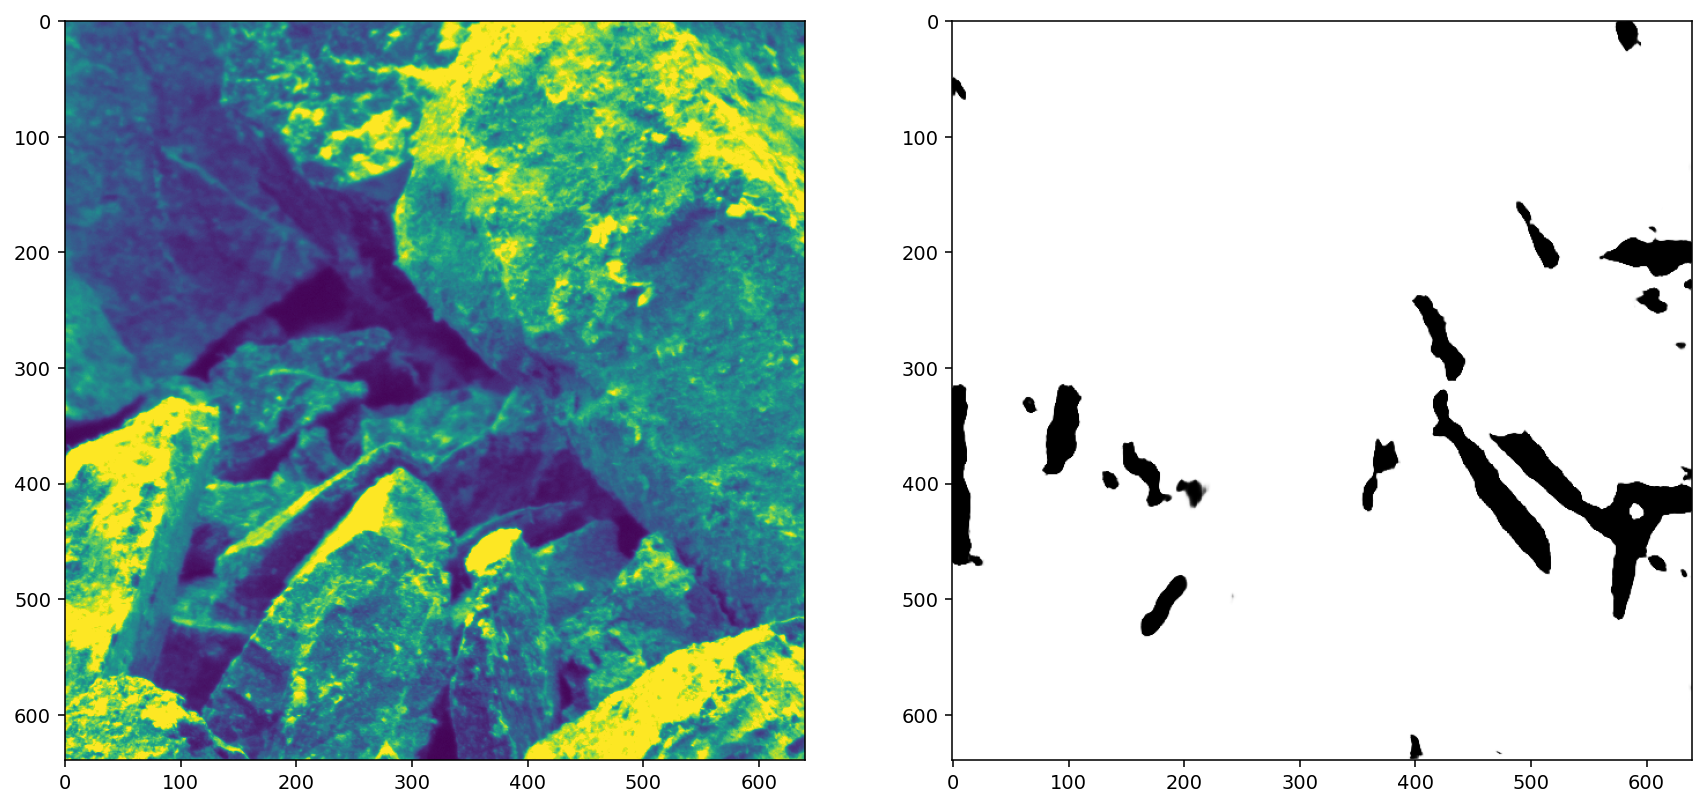

In [13]:
fig, ax = plt.subplots(1,2, figsize = (15,15), dpi = 140)
ax[0].imshow(image[0][0].detach().cpu().numpy(), )
# ax[1].imshow(image[0][0].detach().cpu().numpy(), )
ax[1].imshow(pred_mask, cmap='Greys')
# ax[2].imshow(mask[0].detach().cpu().numpy(), cmap='Greys')

['Full_637437067053998640.bmp', 'Full_637437067296374854.bmp']

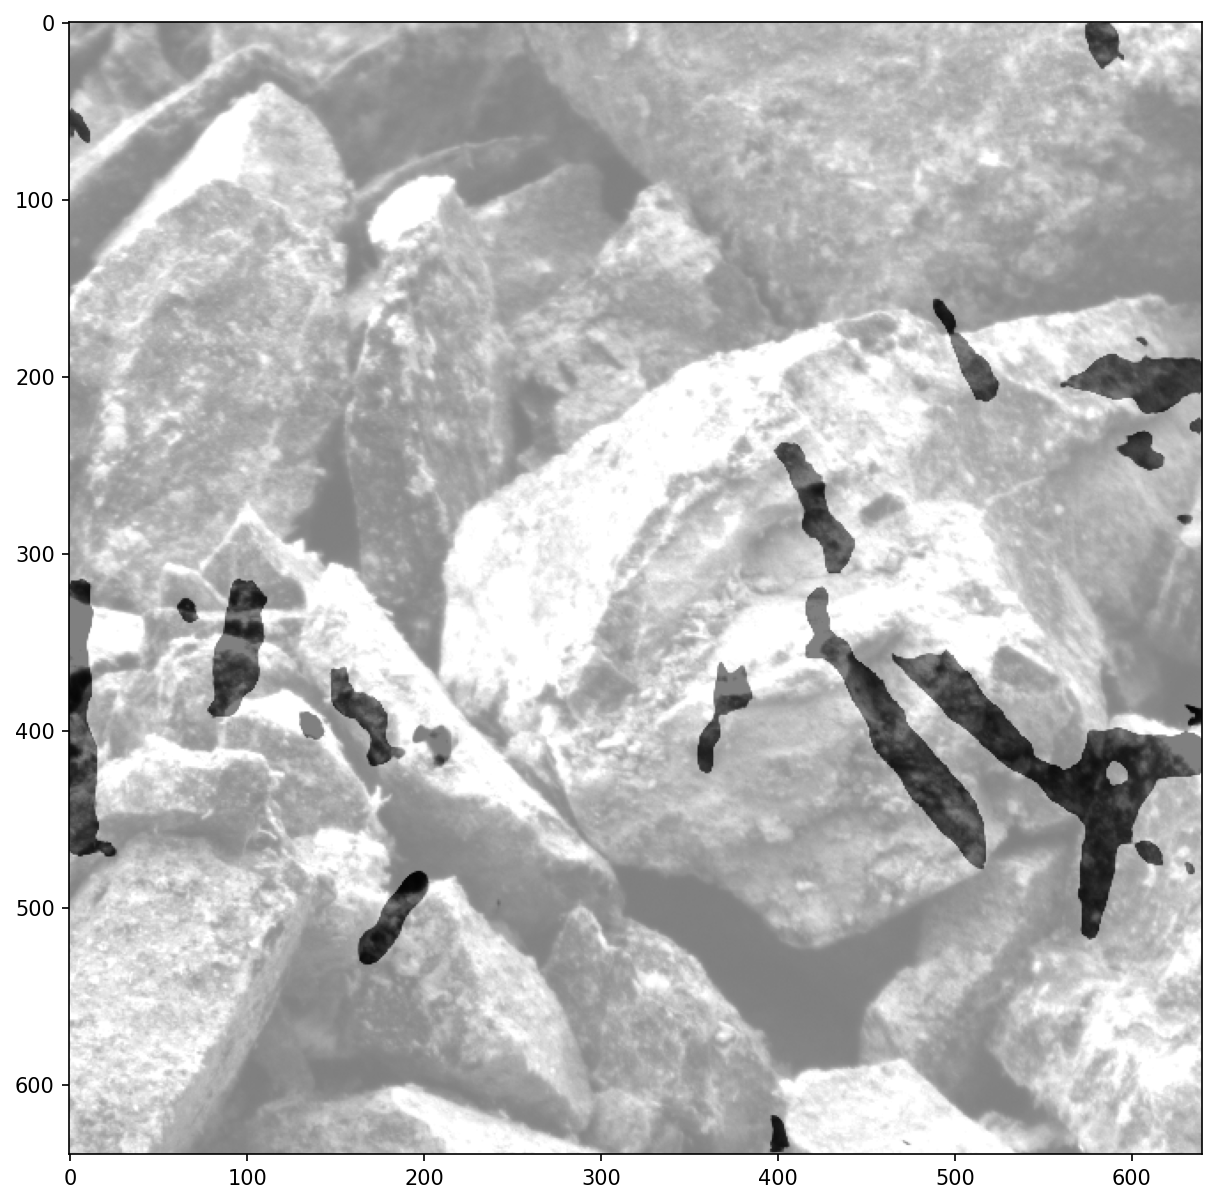

In [20]:
# fig, ax = plt.subplots(1, figsize = (15,15), dpi = 140)
fig = plt.subplots(figsize = (10,10), dpi = 150)
plt.imshow(image[0][0].detach().cpu().numpy(),cmap='gray')
plt.imshow(pred_mask, cmap='Greys', alpha =0.5)
name

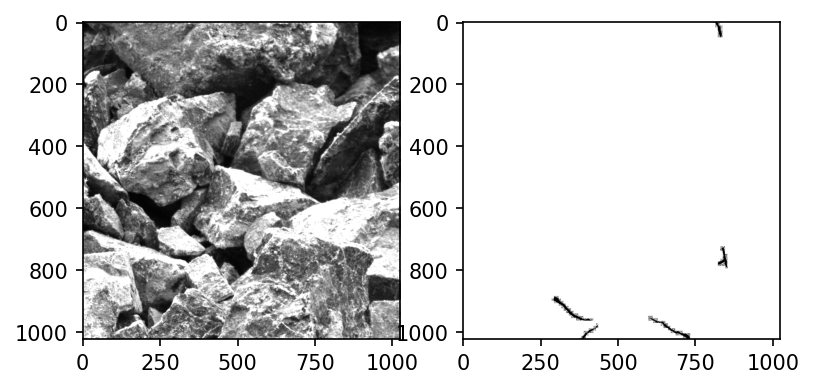

In [119]:
ex = next(data_loader.__iter__())

image = ex['image']
mask = ex['mask']

fig, ax = plt.subplots(1,2, dpi = 150)

ax[0].imshow(image[0].detach().numpy(), cmap='gray')
ax[1].imshow(mask[0].detach().numpy(), cmap='Greys')